In [1]:
library("readr")
library("e1071")
library("corrplot")
library("Metrics")
library("caret")
library("dplyr")
library("randomForest")

Warning message:
"package 'readr' was built under R version 4.2.3"
Warning message:
"package 'e1071' was built under R version 4.2.3"
Warning message:
"package 'corrplot' was built under R version 4.2.3"
corrplot 0.92 loaded

Warning message:
"package 'Metrics' was built under R version 4.2.3"
Warning message:
"package 'caret' was built under R version 4.2.3"
Loading required package: ggplot2

Warning message:
"package 'ggplot2' was built under R version 4.2.3"
Loading required package: lattice


Attaching package: 'caret'


The following objects are masked from 'package:Metrics':

    precision, recall


Warning message:
"package 'dplyr' was built under R version 4.2.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'randomForest' was built under R version 4.2.3"
randomForest 4.7-1.1

Type rfNews() to see ne

In [2]:
train_V2 <- read_csv("train_V2.csv")

Rows: 4446966 Columns: 29
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): Id, groupId, matchId, matchType
dbl (25): assists, boosts, damageDealt, DBNOs, headshotKills, heals, killPla...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


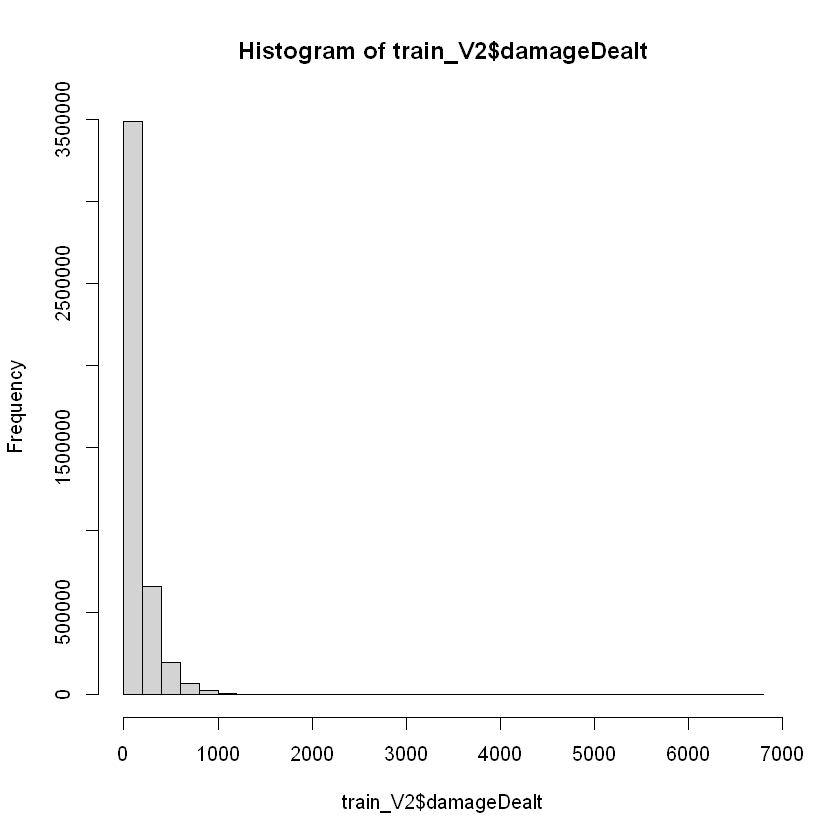

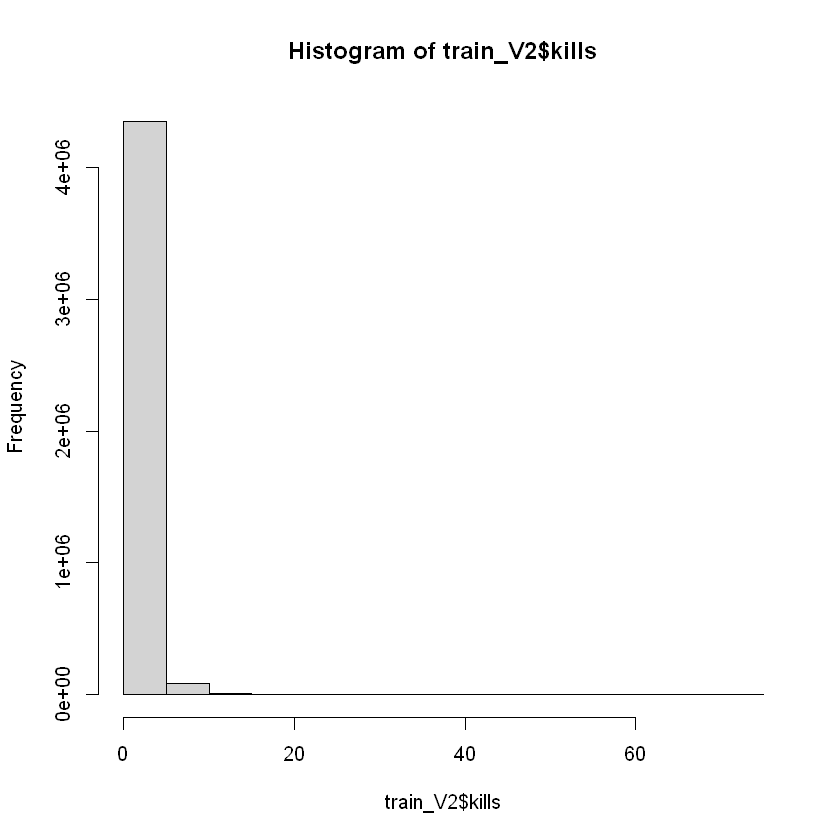

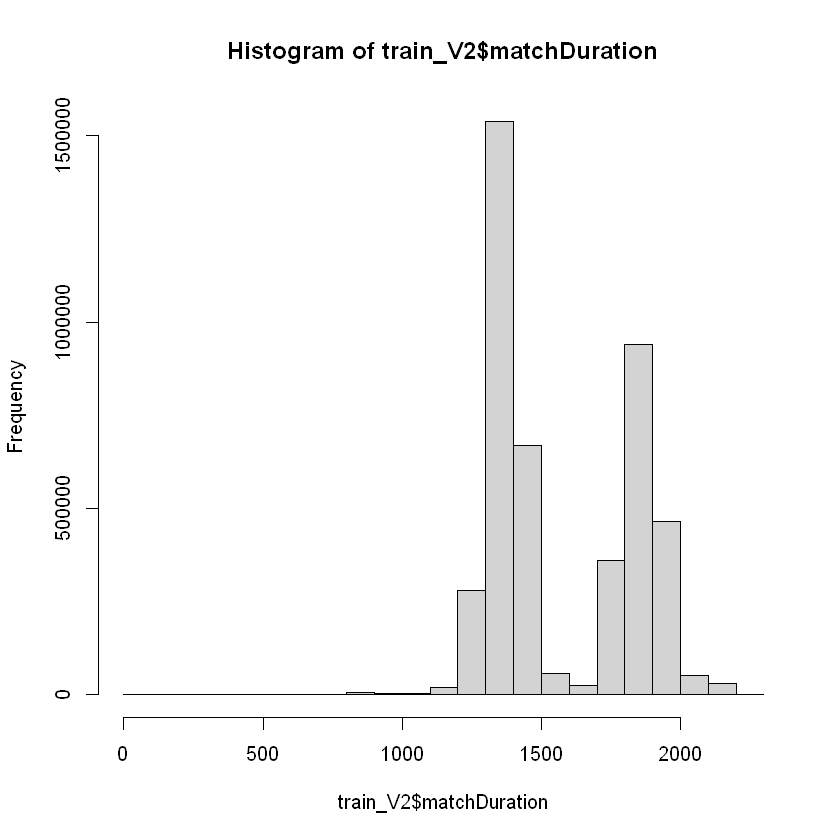

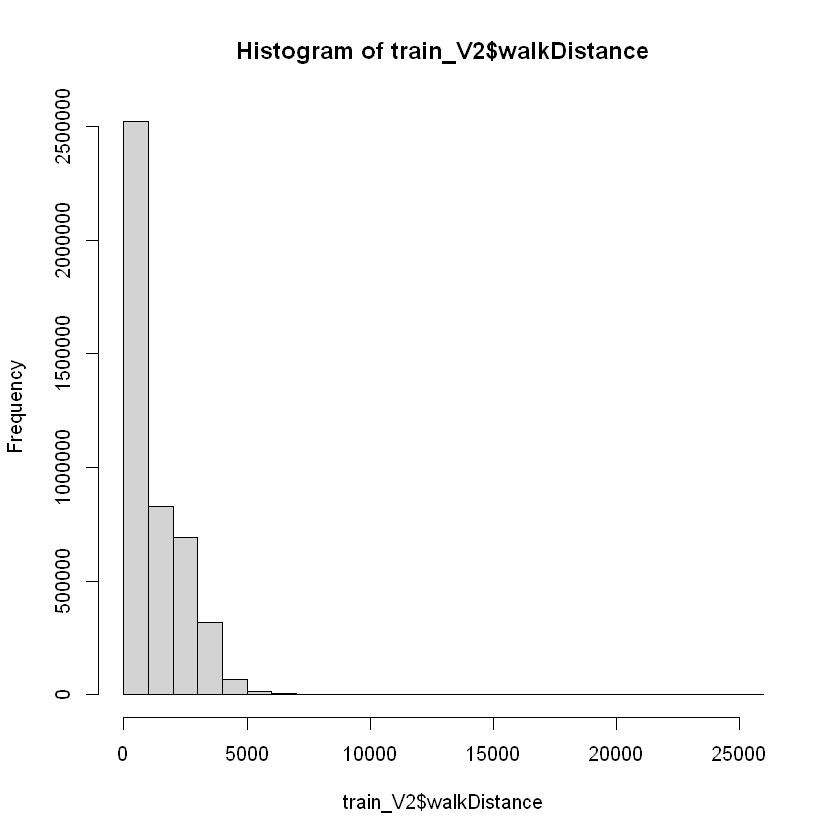

In [3]:

# Histograms to analyze and explore the dataset
hist(train_V2$damageDealt)
hist(train_V2$kills)
hist(train_V2$matchDuration)
hist(train_V2$walkDistance)

In [4]:
summary(train_V2)

      Id              groupId            matchId             assists       
 Length:4446966     Length:4446966     Length:4446966     Min.   : 0.0000  
 Class :character   Class :character   Class :character   1st Qu.: 0.0000  
 Mode  :character   Mode  :character   Mode  :character   Median : 0.0000  
                                                          Mean   : 0.2338  
                                                          3rd Qu.: 0.0000  
                                                          Max.   :22.0000  
                                                                           
     boosts        damageDealt          DBNOs         headshotKills    
 Min.   : 0.000   Min.   :   0.00   Min.   : 0.0000   Min.   : 0.0000  
 1st Qu.: 0.000   1st Qu.:   0.00   1st Qu.: 0.0000   1st Qu.: 0.0000  
 Median : 0.000   Median :  84.24   Median : 0.0000   Median : 0.0000  
 Mean   : 1.107   Mean   : 130.72   Mean   : 0.6579   Mean   : 0.2268  
 3rd Qu.: 2.000   3rd Qu.: 186.0

In [5]:
# Clean NAs, unused attributes, and outliers from the data
train_V2_clean <- na.omit(train_V2)
train_V2_clean <- subset(train_V2_clean, select =-c(killPoints, rankPoints, winPoints))
train_V2_clean <- subset(train_V2_clean, train_V2_clean$matchDuration != 9)
train_V2_clean <- subset(train_V2_clean, train_V2_clean$kills < 50)

In [6]:
# Use an 80 20 split to create our own train/test sets
smp_size <- floor(0.80 * nrow(train_V2_clean))
set.seed(123)
train_ind <- sample(seq_len(nrow(train_V2_clean)), size = smp_size)
pubg_train <- train_V2_clean[train_ind, ]
pubg_test <- train_V2_clean[-train_ind, ]

In [7]:
#Reduce the shuffled train and test sets
pubg_train_reduced = pubg_train[1:10000,]
pubg_test_reduced = pubg_test[1:2000,]

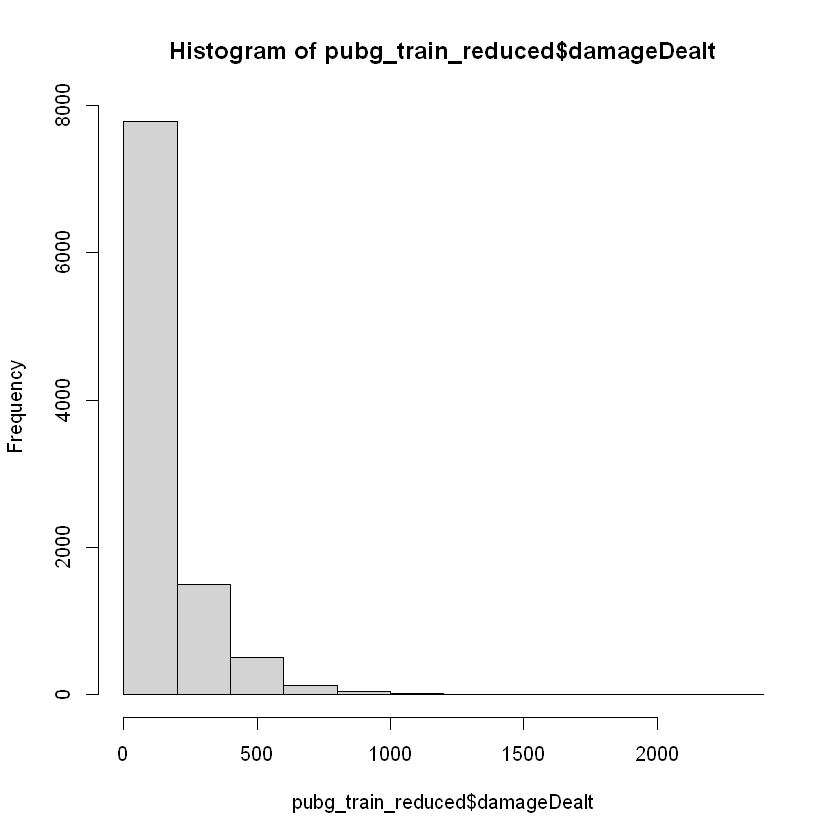

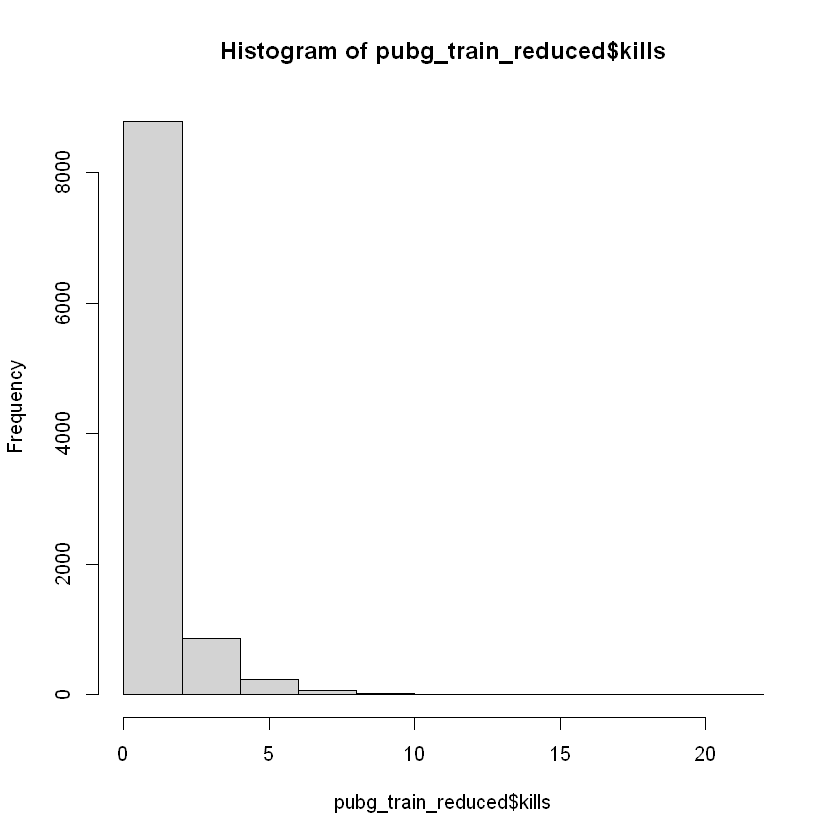

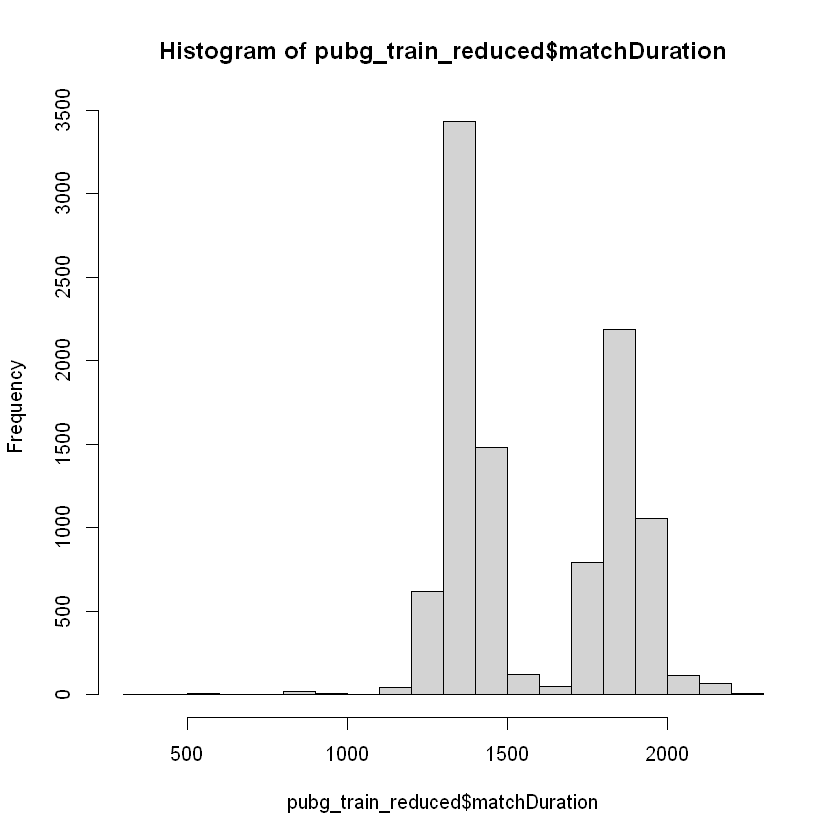

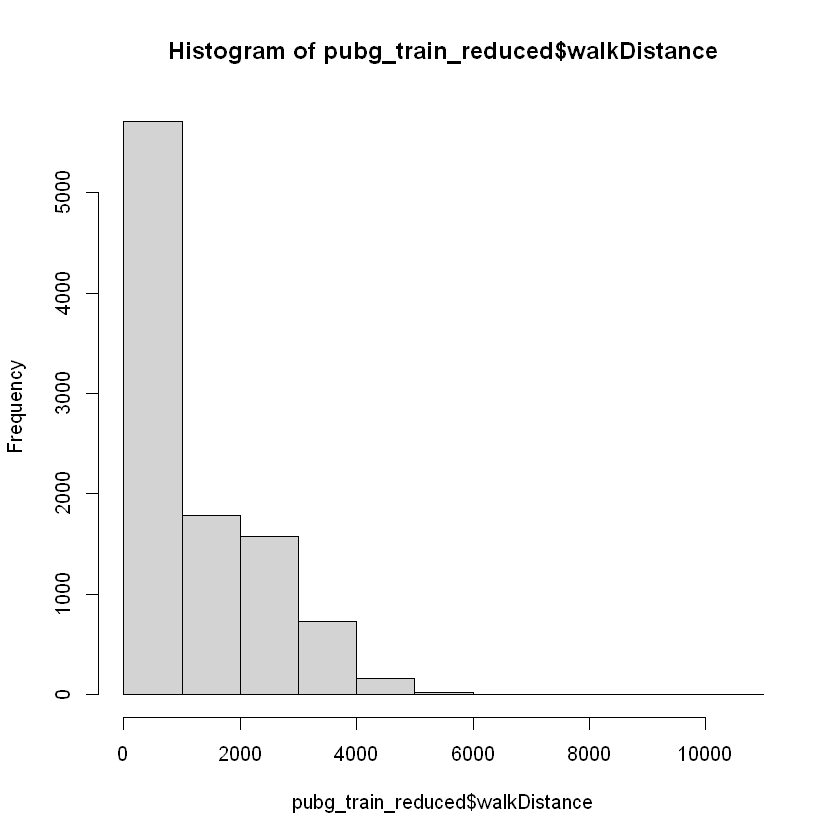

In [8]:
# Exploring Dataset after cleaning and reduction
hist(pubg_train_reduced$damageDealt)
hist(pubg_train_reduced$kills)
hist(pubg_train_reduced$matchDuration)
hist(pubg_train_reduced$walkDistance)

In [9]:
summary(pubg_train_reduced)
summary(pubg_test_reduced)

      Id              groupId            matchId             assists     
 Length:10000       Length:10000       Length:10000       Min.   :0.000  
 Class :character   Class :character   Class :character   1st Qu.:0.000  
 Mode  :character   Mode  :character   Mode  :character   Median :0.000  
                                                          Mean   :0.229  
                                                          3rd Qu.:0.000  
                                                          Max.   :6.000  
     boosts        damageDealt         DBNOs         headshotKills    
 Min.   : 0.000   Min.   :   0.0   Min.   : 0.0000   Min.   : 0.0000  
 1st Qu.: 0.000   1st Qu.:   0.0   1st Qu.: 0.0000   1st Qu.: 0.0000  
 Median : 0.000   Median :  86.0   Median : 0.0000   Median : 0.0000  
 Mean   : 1.127   Mean   : 131.2   Mean   : 0.6596   Mean   : 0.2251  
 3rd Qu.: 2.000   3rd Qu.: 188.1   3rd Qu.: 1.0000   3rd Qu.: 0.0000  
 Max.   :12.000   Max.   :2214.0   Max.   :14.0000   Max

      Id              groupId            matchId             assists     
 Length:2000        Length:2000        Length:2000        Min.   :0.000  
 Class :character   Class :character   Class :character   1st Qu.:0.000  
 Mode  :character   Mode  :character   Mode  :character   Median :0.000  
                                                          Mean   :0.214  
                                                          3rd Qu.:0.000  
                                                          Max.   :5.000  
     boosts        damageDealt          DBNOs        headshotKills   
 Min.   : 0.000   Min.   :   0.00   Min.   : 0.000   Min.   :0.0000  
 1st Qu.: 0.000   1st Qu.:   0.00   1st Qu.: 0.000   1st Qu.:0.0000  
 Median : 0.000   Median :  84.22   Median : 0.000   Median :0.0000  
 Mean   : 1.145   Mean   : 136.82   Mean   : 0.671   Mean   :0.2505  
 3rd Qu.: 2.000   3rd Qu.: 195.60   3rd Qu.: 1.000   3rd Qu.:0.0000  
 Max.   :13.000   Max.   :2325.00   Max.   :13.000   Max.   :8

In [10]:
# Create dataframes with the string variables removed. This will be used in some of the Methods
pubg_train_reduced_stringless <- subset(pubg_train_reduced, select = -c(Id, groupId, matchId, matchType))
pubg_test_reduced_stringless <- subset(pubg_test_reduced, select = -c(Id, groupId, matchId, matchType))

In [11]:
solo_train <- subset(pubg_train_reduced_stringless , pubg_train_reduced$matchType == "solo") 
duo_train <- subset(pubg_train_reduced_stringless , pubg_train_reduced$matchType == "duo") 
squad_train <- subset(pubg_train_reduced_stringless , pubg_train_reduced$matchType == "squad") 
solo_fpp_train <- subset(pubg_train_reduced_stringless , pubg_train_reduced$matchType == "solo-fpp") 
duo_fpp_train <- subset(pubg_train_reduced_stringless , pubg_train_reduced$matchType == "duo-fpp")
squad_fpp_train <-  subset(pubg_train_reduced_stringless , pubg_train_reduced$matchType == "duo-fpp")

In [12]:
solo_test <- subset(pubg_test_reduced_stringless , pubg_test_reduced$matchType == "solo") 
duo_test <- subset(pubg_test_reduced_stringless , pubg_test_reduced$matchType == "duo") 
squad_test <- subset(pubg_test_reduced_stringless , pubg_test_reduced$matchType == "squad") 
solo_fpp_test <- subset(pubg_test_reduced_stringless , pubg_test_reduced$matchType == "solo-fpp") 
duo_fpp_test <- subset(pubg_test_reduced_stringless , pubg_test_reduced$matchType == "duo-fpp")
squad_fpp_test <-  subset(pubg_test_reduced_stringless , pubg_test_reduced$matchType == "duo-fpp")

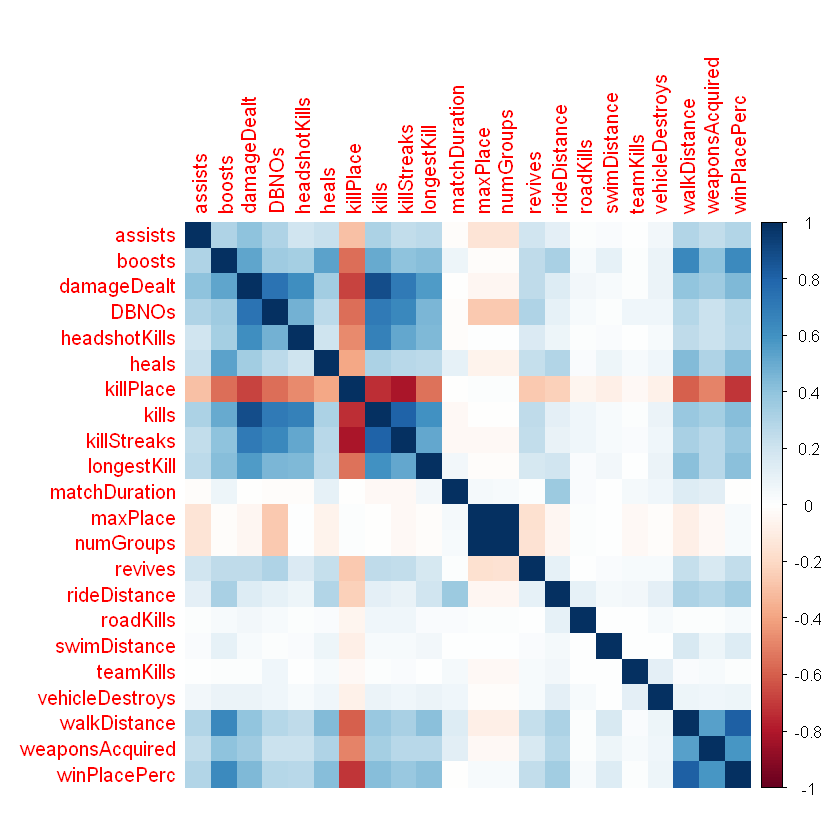

In [13]:
### Method 2 - Correlation matrix
set <- subset(train_V2_clean, select = -c(Id, groupId, matchId, matchType)) 
corr_full <- cor(set, method="pearson")
corrplot(corr_full, method='color')

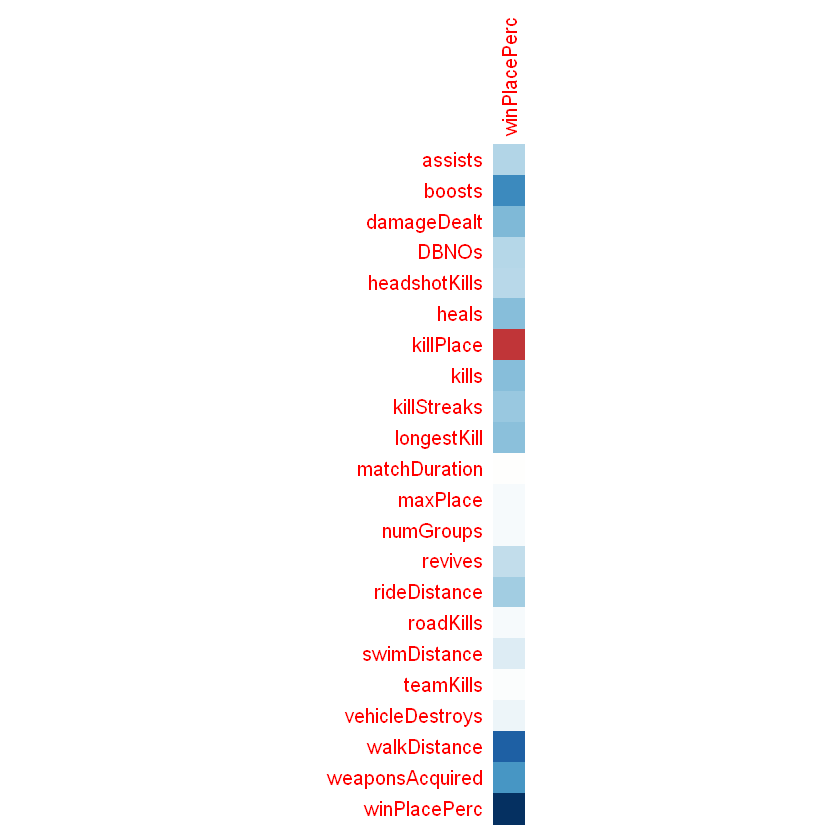

In [14]:
#Plot focusing on winPlacePerc
corr_winPerc <- cor(set[,1:22], method="pearson")
corrplot(corr_winPerc[1:22,22, drop=FALSE], cl.pos='n', method='color')

In [ ]:
### Method 3 - Linear/Logistic Regression

# Create a model using the train data where all matchTypes are present
model_lm <- lm(winPlacePerc ~ ., data = pubg_train_reduced)

# Use the model from above to predict the entire test data
mae(pubg_test_reduced$winPlacePerc, predict(model_lm))

In [ ]:
# Use the model above to predict the test data one matchType subset at a time

mae(solo_test$winPlacePerc, predict(model_lm))
mae(duo_test$winPlacePerc, predict(model_lm))
mae(squad_test$winPlacePerc, predict(model_lm))
mae(solo_fpp_test$winPlacePerc, predict(model_lm))
mae(duo_fpp_test$winPlacePerc, predict(model_lm))
mae(squad_fpp_test$winPlacePerc, predict(model_lm))

In [ ]:
# For each matchType subset, create a its own train model and use that to predict its test data

linear_solo <- lm(winPlacePerc ~ ., data = solo_train)
mae(solo_test$winPlacePerc, predict(linear_solo))

linear_duo <- lm(winPlacePerc ~ ., data = duo_train)
mae(duo_test$winPlacePerc, predict(linear_duo))

linear_squad <- lm(winPlacePerc ~ ., data = squad_train)
mae(squad_test$winPlacePerc, predict(linear_squad))


linear_solo_fpp <- lm(winPlacePerc ~ ., data = solo_fpp_train)
mae(solo_fpp_test$winPlacePerc, predict(linear_solo_fpp))

linear_duo_fpp <- lm(winPlacePerc ~ ., data = duo_fpp_train)
mae(duo_fpp_test$winPlacePerc, predict(linear_duo_fpp))

linear_squad_fpp <- lm(winPlacePerc ~ ., data = squad_fpp_train)
mae(squad_fpp_test$winPlacePerc, predict(linear_squad_fpp))

In [15]:
# Method 4 - Support Vector Regression(SVR)

svr_train <- subset(pubg_train_reduced, select = -c(Id, groupId, matchId, matchType)) 
svr_test <- subset(pubg_test_reduced, select = -c(Id, groupId, matchId, matchType, winPlacePerc))

In [16]:
model_svm <- svm(winPlacePerc ~ ., svr_train)
predictions <-  predict(model_svm,svr_test)

mae <- mean(abs(predictions - pubg_test_reduced$winPlacePerc))
print(paste("Mean Absolute Error (MAE):", mae))

[1] "Mean Absolute Error (MAE): 0.0685556217206718"


In [ ]:

Opt_svm=tune(svm, winPlacePerc ~ ., data=svr_train,ranges=list(elsilon=seq(0,1,0.2), cost=seq(1,100,10)))

#Print optimum value of parameters
print(Opt_svm)

#Plot the perfrormance of SVM Regression model
plot(Opt_svm)

#Find out the best model
Best_svm=OptModelsvm$best.model


In [ ]:
predictions <-  predict(Best_svm,svr_test)

mae <- mean(abs(predictions - pubg_test_reduced$winPlacePerc))
print(paste("Mean Absolute Error (MAE):", mae))

In [ ]:
predictions <-  predict(OptModelsvm,solo_test)

mae <- mean(abs(predictions - solo_test$winPlacePerc))
print(paste("Mean Absolute Error (MAE):", mae))

predictions <-  predict(OptModelsvm,duo_test)

mae <- mean(abs(predictions - duo_test$winPlacePerc))
print(paste("Mean Absolute Error (MAE):", mae))

predictions <-  predict(OptModelsvm,squad_test)

mae <- mean(abs(predictions - squad_test$winPlacePerc))
print(paste("Mean Absolute Error (MAE):", mae))

predictions <-  predict(OptModelsvm,squad_fpp_test)

mae <- mean(abs(predictions - squad_fpp_test$winPlacePerc))
print(paste("Mean Absolute Error (MAE):", mae))

predictions <-  predict(OptModelsvm,duo_fpp_test)

mae <- mean(abs(predictions - duo_fpp_test$winPlacePerc))
print(paste("Mean Absolute Error (MAE):", mae))

predictions <-  predict(OptModelsvm,solo_fpp_test)

mae <- mean(abs(predictions - solo_fpp_test$winPlacePerc))
print(paste("Mean Absolute Error (MAE):", mae))

In [ ]:
# Method 5 - Random Forest Regressor

set.seed(42)
model_rf <- randomForest(formula = winPlacePerc ~ ., data = pubg_train_reduced, mtry = 10, ntree = 500)
predictions <- predict(model_rf, newdata = pubg_test_reduced)

mae <- mean(abs(predictions - pubg_test_reduced$winPlacePerc))
print(paste("Mean Absolute Error (MAE):", mae))